## 1. Importing the required libraries

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, gamma , lognorm
from sklearn.mixture import GaussianMixture

# Set visual style
sns.set(style="whitegrid")
print("Successfully imported All Libraries")

Successfully imported All Libraries


## 2. Data Loading and Preprocessing

In [67]:
# Load the dataset
df = pd.read_csv('/Users/kevinharvey/Desktop/Projects/Statistics Project/rainfall in india 1901-2015.csv')

# Drop rows with missing annual rainfall for accurate analysis
df = df.dropna(subset=['ANNUAL'])

print(f"Dataset shape after cleaning: {df.shape}")
df[['ANNUAL']].describe()

Dataset shape after cleaning: (4090, 19)


,ANNUAL
count,4090.000000
mean,1411.008900
std,903.846565
min,62.300000
25%,804.500000
50%,1121.300000
75%,1644.775000
max,6331.100000


## 3. Rainfall Intensity Probabilities

In [68]:
# Define Intensity Categories based on Quantiles
quantiles = df['ANNUAL'].quantile([0.2, 0.4, 0.6, 0.8])
print("Intensity Thresholds (Quantiles):")
print(quantiles)

def categorize_intensity(x):
    if x <= quantiles[0.2]: return 'Very Low'
    elif x <= quantiles[0.4]: return 'Low'
    elif x <= quantiles[0.6]: return 'Moderate'
    elif x <= quantiles[0.8]: return 'High'
    else: return 'Extreme'

df['Intensity_Category'] = df['ANNUAL'].apply(categorize_intensity)

# Calculate Empirical Probabilities
intensity_counts = df['Intensity_Category'].value_counts()
intensity_probs = intensity_counts / len(df)
print("\nEmpirical Probabilities of Rainfall Intensities:")
print(intensity_probs)

# Probability of Exceeding a certain threshold (For the sake of examples: 2000mm)
threshold = 2000
prob_exceed = (df['ANNUAL'] > threshold).mean()
print(f"\nProbability of annual rainfall intensity exceeding {threshold}mm: {prob_exceed:.4f}")

Intensity Thresholds (Quantiles):
0.2     738.58
0.4     992.72
0.6    1278.02
0.8    2189.54
Name: ANNUAL, dtype: float64

Empirical Probabilities of Rainfall Intensities:
Intensity_Category
Extreme     0.2
High        0.2
Moderate    0.2
Low         0.2
Very Low    0.2
Name: count, dtype: float64

Probability of annual rainfall intensity exceeding 2000mm: 0.2108


## 4. Comparison with Theoretical Distributions

In [ ]:
annual_data = df['ANNUAL'].values

# 1. Fit Theoretical Distributions
mu, std = stats.norm.fit(annual_data)
gamma_params = stats.gamma.fit(annual_data)
lognorm_params = stats.lognorm.fit(annual_data)

# 2. Calculate Log-Likelihoods for comparison
log_lik_norm = np.sum(stats.norm.logpdf(annual_data, mu, std))
log_lik_gamma = np.sum(stats.gamma.logpdf(annual_data, *gamma_params))
log_lik_lognorm = np.sum(stats.lognorm.logpdf(annual_data, *lognorm_params))

results_df = pd.DataFrame({
    'Distribution': ['Normal', 'Gamma', 'Lognormal'],
    'Log-Likelihood': [log_lik_norm, log_lik_gamma, log_lik_lognorm],
    'Params': [f'mu={mu:.1f}, std={std:.1f}', f'shape={gamma_params[0]:.2f}', f'shape={lognorm_params[0]:.2f}']
})
print("--- Distribution Fitting Results ---")
print(results_df)

# 3. Visualization: PDF and ECDF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
x = np.linspace(annual_data.min(), annual_data.max(), 100)

# Plot 1: PDF Comparison
sns.histplot(annual_data, kde=True, stat="density", color='lightgray', ax=ax1, label='Empirical (KDE)')
ax1.plot(x, stats.norm.pdf(x, mu, std), 'r-', lw=2, label='Normal')
ax1.plot(x, stats.gamma.pdf(x, *gamma_params), 'g--', lw=2, label='Gamma')
ax1.plot(x, stats.lognorm.pdf(x, *lognorm_params), 'b-.', lw=2, label='Lognormal')
ax1.set_title('PDF Comparison: Fitting Results')
ax1.legend()

# Plot 2: ECDF Comparison
sorted_data = np.sort(annual_data)
ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ax2.step(sorted_data, ecdf, color='black', label='Empirical CDF', where='post')
ax2.plot(x, stats.norm.cdf(x, mu, std), 'r-', label='Normal CDF')
ax2.plot(x, stats.gamma.cdf(x, *gamma_params), 'g--', label='Gamma CDF')
ax2.plot(x, stats.lognorm.cdf(x, *lognorm_params), 'b-.', label='Lognormal CDF')
ax2.set_title('ECDF vs Theoretical CDFs')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. Law of Large Numbers (LLN) Validation


Population Mean of Annual Rainfall: 1411.01 mm


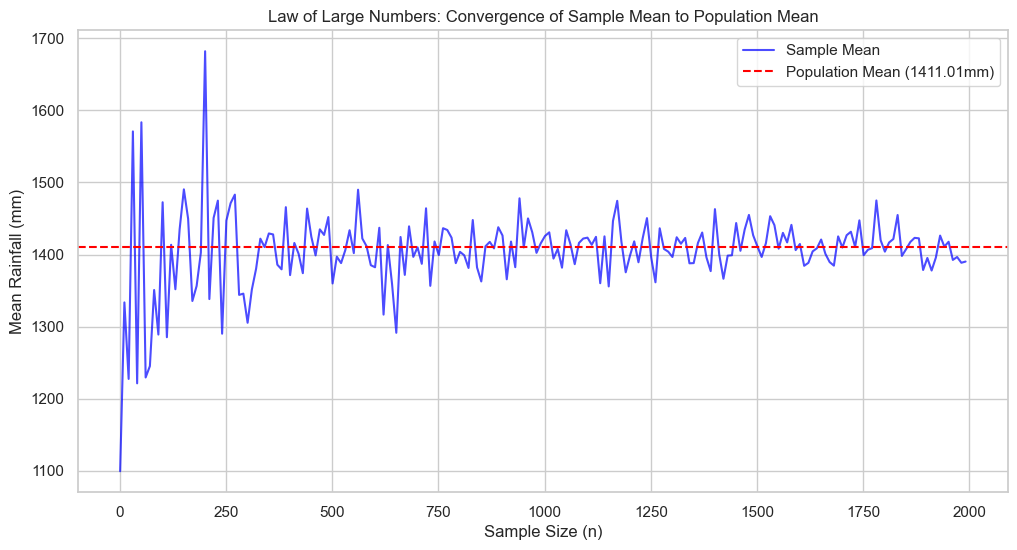

In [70]:
population_mean = annual_data.mean()
print(f"Population Mean of Annual Rainfall: {population_mean:.2f} mm")

# Create samples of increasing size
sample_sizes = np.arange(1, 2001, 10)
sample_means = []

# Shuffle the data to ensure random sampling without replacement
np.random.seed(42)
for n in sample_sizes:
    sample = np.random.choice(annual_data, size=n, replace=True)
    sample_means.append(sample.mean())

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(sample_sizes, sample_means, label='Sample Mean', color='blue', alpha=0.7)
plt.axhline(y=population_mean, color='red', linestyle='--', label=f'Population Mean ({population_mean:.2f}mm)')

plt.title('Law of Large Numbers: Convergence of Sample Mean to Population Mean')
plt.xlabel('Sample Size (n)')
plt.ylabel('Mean Rainfall (mm)')
plt.legend()
plt.show()

## 5. Rainfall Trend Curve Fitting
We will fit a linear and polynomial curve to the annual rainfall data over time to see if there's a significant trend.

In [ ]:
# Aggregating total annual rainfall by year
yearly_avg = df.groupby('YEAR')['ANNUAL'].mean().reset_index()
X = yearly_avg['YEAR']
Y = yearly_avg['ANNUAL']

# Linear Curve Fitting
z1 = np.polyfit(X, Y, 1)
p1 = np.poly1d(z1)

# Quadratic Curve Fitting
z2 = np.polyfit(X, Y, 2)
p2 = np.poly1d(z2)

plt.figure(figsize=(12, 6))
plt.scatter(X, Y, color='lightgray', s=20, label='Actual Yearly Mean')
plt.plot(X, p1(X), 'r--', lw=2, label=f'Linear Fit (slope={z1[0]:.4f})')
plt.plot(X, p2(X), 'b-', lw=2, label='Quadratic Fit')
plt.title('Rainfall Trend over Years: Curve Fitting Analysis')
plt.xlabel('Year')
plt.ylabel('Annual Rainfall (mm)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Rainfall Probability Equation Model
Based on our Log-Likelihood and ECDF analysis, we can identify THE mathematical model for rainfall probability.

### Mathematical Representation (Best Fit: Gamma)
The **Gamma Distribution** often provides the most robust fit for rainfall data. Its Probability Density Function (PDF) is given by:

$$ f(x; a, \theta) = \frac{x^{a-1} e^{-x/\theta}}{\theta^a \Gamma(a)} $$

Where:
- $a$ is the **shape** parameter.
- $\theta$ is the **scale** parameter.

In [ ]:
def get_rainfall_probability(value, dist_type='gamma'):
    if dist_type == 'gamma':
        cdf = stats.gamma.cdf(value, *gamma_params)
        dist_name = 'Gamma'
    elif dist_type == 'lognorm':
        cdf = stats.lognorm.cdf(value, *lognorm_params)
        dist_name = 'Lognormal'
    else:
        cdf = stats.norm.cdf(value, mu, std)
        dist_name = 'Normal'
    
    exceedance = 1 - cdf
    print(f'--- Probability Analysis for {value}mm ({dist_name} Model) ---')
    print(f'Probability of rainfall <= {value}mm: {cdf*100:.2f}%')
    print(f'Exceedance Probability (rainfall > {value}mm): {exceedance*100:.2f}%')
    return cdf, exceedance

# Example usage
get_rainfall_probability(2500, dist_type='gamma')